In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from torchsummary import summary

import shutil
from torch import Tensor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed

In [2]:
# data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
# paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
# min_samples = 384

# def extract_samples(path):
#     df = pd.read_csv(path, index_col=0, header=None).T
#     return df.shape[0]

# samples = Parallel(n_jobs=-1)(delayed(extract_samples)(path) for path in paths)
# min_number_of_samples = min(samples)
min_number_of_samples = 360

In [4]:
# data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
# paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
# X_train, X_test, _, _ = train_test_split(paths, paths, test_size=0.2, shuffle=True)

# for file in os.listdir("..\Training Data\BrainVis_Preprocessing\eegs\\test"):
#     os.remove(os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\test", file))

# for file in os.listdir("..\Training Data\BrainVis_Preprocessing\eegs\\train"):
#     os.remove(os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\train", file))

# for path in X_test:
#     example_path = str(path)
#     segments = example_path.split("\\")
#     file_name = segments[-1]
#     shutil.copyfile(path, os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\test", file_name))
    
# for path in X_train:
#     example_path = str(path)
#     segments = example_path.split("\\")
#     file_name = segments[-1]
#     shutil.copyfile(path, os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\train", file_name))

In [9]:
class EEG_DataSet(Dataset):
    def __init__(self, eegs_dir, transform=None, target_transform=None):
        self.eegs_dir = eegs_dir
        self.eeg_examples = Parallel(n_jobs=-1)(delayed(EEG_DataSet.extract_sample)(os.path.join(eegs_dir, path)) for path in os.listdir(eegs_dir))
        self.transform = transform
        self.target_transform = target_transform

    @classmethod    
    def extract_sample(cls, sample_path):
        eeg_df = pd.read_csv(sample_path, index_col=0, header=None).T
        eeg_npArray = np.array(eeg_df, dtype=np.float32)[:min_number_of_samples]
        return eeg_npArray

    def __len__(self):
        return len(self.eeg_examples)

    def __getitem__(self, idx):
        eeg_npArray  = self.eeg_examples[idx].T
        eeg_npArray = eeg_npArray[:, :, np.newaxis]
        eeg_tensor = torch.tensor(eeg_npArray, dtype=torch.float32)
        
        if self.transform: eeg_tensor = self.transform(eeg_tensor)
        if self.target_transform: eeg_tensor = self.target_transform(eeg_tensor)
        return eeg_tensor, eeg_tensor

train_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\train",)
test_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\test",)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128)

In [17]:
class Encode(nn.Module):
    def __init__(self, num_channels, channel_size, latent_dim):
        super(Encode, self).__init__()
        encode_ratio = 32
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, encode_ratio, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(encode_ratio, encode_ratio*2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(encode_ratio*2, encode_ratio*4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64800, latent_dim))
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64800),
            nn.
            nn.ConvTranspose2d(30, 15, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 5, kernel_size=3, stride=2, padding=(2,1), output_padding=(1, 0)),
            )
        
    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape[1:])
        x = self.decoder(x)
        print("Shape after decode:", x.shape)
        return x
    
model = Autoencoder(num_channels=5,
                    channel_size=min_number_of_samples,
                    latent_dim=500)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    batch_loss = []
    for data in train_loader:
        eeg, _ = data
        eeg = eeg.to(device)
        optimizer.zero_grad()
        output = model(eeg)
        loss = criterion(output, eeg)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
    losses.append(np.mean(batch_loss))

    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

cuda
torch.Size([128, 45, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (737280x1 and 500x64800)

In [7]:
test_loss = []
for data in test_loader:
    eeg, _ = data
    eeg = eeg.to(device)
    output = model(eeg)
    loss = criterion(output, eeg)

    test_loss.append(loss.item())

print(f"Average testing loss: {round(np.mean(test_loss), 4)}")

Average testing loss: 3552859.7045


In [13]:
losses

[13627907.420454545,
 4061756.9517045454,
 3568705.840909091,
 3563828.2443181816,
 3563211.65625,
 3562400.772727273,
 3561571.696022727,
 3560816.1306818184,
 3560097.2926136362,
 3559286.553977273,
 3558578.4261363638,
 3557891.5880681816,
 3557193.0170454546,
 3556505.065340909,
 3555608.335227273,
 3554936.8267045454,
 3554668.6818181816,
 3554574.6676136362,
 3554439.133522727,
 3554294.471590909,
 3554259.034090909,
 3554229.1051136362,
 3554107.102272727,
 3554038.534090909,
 3553930.0113636362,
 3553932.8892045454,
 3553809.903409091,
 3553812.971590909,
 3553789.53125,
 3553745.940340909,
 3553753.4119318184,
 3553585.184659091,
 3553595.7642045454,
 3553486.471590909,
 3553599.59375,
 3553433.340909091,
 3553383.977272727,
 3553304.1392045454,
 3553243.4119318184,
 3553101.508522727,
 3553011.465909091,
 3552871.178977273,
 3552768.8693181816,
 3552701.377840909,
 3552585.210227273,
 3552511.1448863638,
 3552319.122159091,
 3552116.5738636362,
 3552042.15625,
 3551900.75]

(0.0, 100000.0)

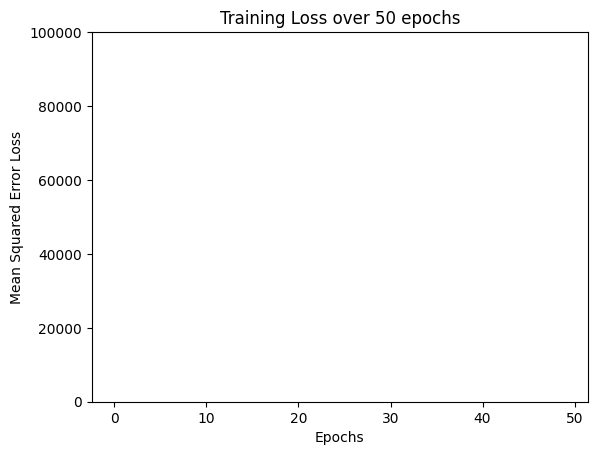

In [9]:
plt.plot(losses)
plt.ylabel("Mean Squared Error Loss")
plt.xlabel("Epochs")
plt.title(f"Training Loss over {num_epochs} epochs")
plt.ylim(0,100000)

Text(0.5, 1.0, 'Sample EEG')

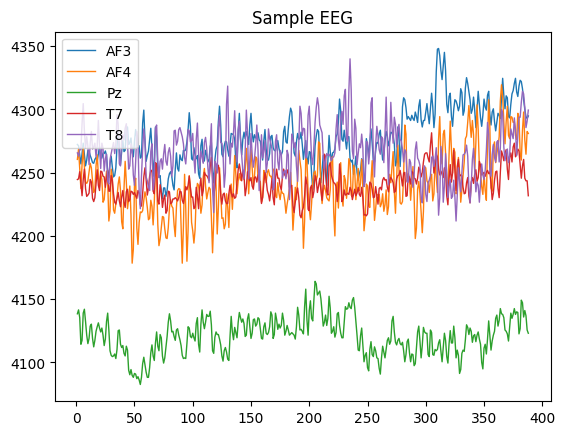

In [15]:
data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

df = pd.read_csv(paths[0], index_col=0, header=None).T

# npArray = np.array(df, dtype=np.float32)[:min_number_of_samples].reshape(5,min_number_of_samples,1)
# pyTorch_tensory = Tensor(npArray).to(device)
# output = model(pyTorch_tensory)
# print(f"Output shape: {output.shape}")
# for channel in output:
#     channel = channel.reshape(360).cpu().detach().numpy()
#     plt.plot(channel, linewidth=1)

for channel in ["AF3", "AF4", "Pz", "T7", "T8"]:
    plt.plot(df[channel], label=channel, linewidth=1)
plt.legend()
plt.title("Sample EEG")

In [11]:
data_path = "..\\Training Data\\MindBigData\\MindBigData-Imagenet-IN\\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

# Read the first CSV file and transpose it
df = pd.read_csv(paths[0], index_col=0, header=None).T

# Define your channel names
channels = ["AF3", "AF4", "Pz", "T7", "T8"]

# Ensure the DataFrame has the correct columns
df = df[channels]

# Limit the number of samples if necessary
df = df.iloc[:min_number_of_samples]

# Process the data as per your existing code
npArray = np.array(df, dtype=np.float32).reshape(len(channels), min_number_of_samples, 1)
print(npArray.shape)
pyTorch_tensor = Tensor(npArray).to(device)
output = model(pyTorch_tensor)
output.shape

summary(model, (5, 360, 1))

(5, 360, 1)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 360, 1]             150
              ReLU-2           [-1, 15, 360, 1]               0
         MaxPool2d-3           [-1, 15, 181, 1]               0
            Conv2d-4           [-1, 30, 181, 1]             300
              ReLU-5           [-1, 30, 181, 1]               0
         MaxPool2d-6            [-1, 30, 91, 1]               0
   ConvTranspose2d-7           [-1, 15, 181, 1]           4,065
              ReLU-8           [-1, 15, 181, 1]               0
   ConvTranspose2d-9            [-1, 5, 360, 1]             680
             ReLU-10            [-1, 5, 360, 1]               0
Total params: 5,195
Trainable params: 5,195
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 0.02
Est

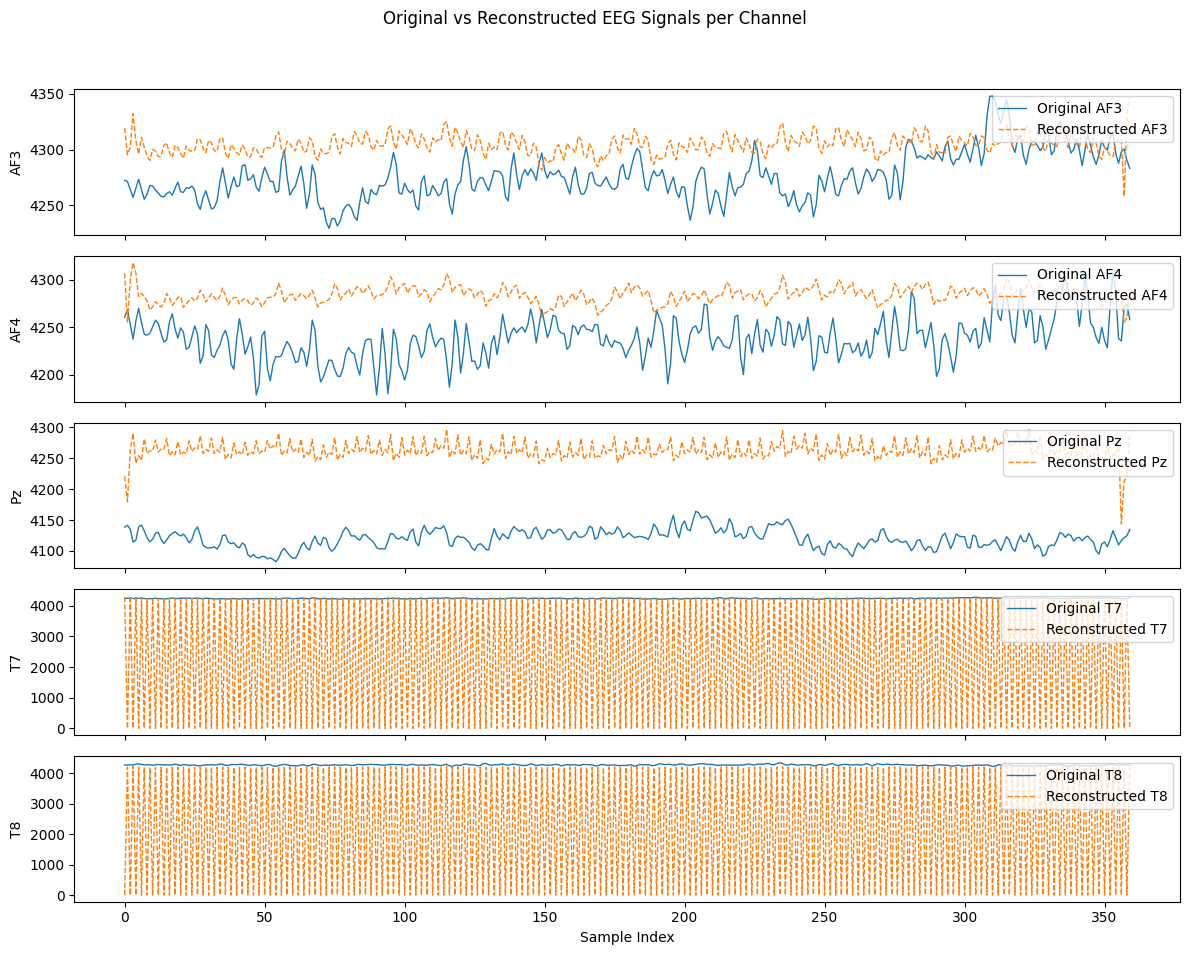

In [12]:
data_path = "..\\Training Data\\MindBigData\\MindBigData-Imagenet-IN\\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

# Read the first CSV file and transpose it
df = pd.read_csv(paths[0], index_col=0, header=None).T


# Define your channel names
channels = ["AF3", "AF4", "Pz", "T7", "T8"]

# Ensure the DataFrame has the correct columns
df = df[channels]

# Limit the number of samples if necessary
df = df.iloc[:min_number_of_samples]

# Process the data as per your existing code
npArray = np.array(df, dtype=np.float32).reshape(len(channels), min_number_of_samples, 1)
pyTorch_tensor = Tensor(npArray).to(device)
output = model(pyTorch_tensor)

# Get the model's output and reshape appropriately
output_np = output.cpu().detach().numpy().reshape(len(channels), min_number_of_samples)

# Plot each channel with original and reconstructed signal
fig, axes = plt.subplots(len(channels), 1, figsize=(12, 10), sharex=True)
for idx, channel in enumerate(channels):
    # Plot original signal
    axes[idx].plot(df[channel].values, label=f'Original {channel}', linewidth=1)
    # Plot reconstructed signal
    axes[idx].plot(output_np[idx], label=f'Reconstructed {channel}', linewidth=1, linestyle='--')
    axes[idx].set_ylabel(channel)
    axes[idx].legend(loc='upper right')
axes[-1].set_xlabel('Sample Index')
plt.suptitle('Original vs Reconstructed EEG Signals per Channel')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()